## Config

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from common import *
from competitions import dogscats;

/home/bfortuner/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [6]:
dogscats.make_metadata_file()
TRAIN_PATH = cfg.PATHS['datasets']['inputs']['trn_jpg'] 
TEST_PATH = cfg.PATHS['datasets']['inputs']['tst_jpg'] 
metadata_df = metadata.get_metadata_df(
    cfg.METADATA_PATH)

In [8]:
HARDWARE_CONFIG = {
    'hostname': socket.gethostname(),
    'random_seed': 3,
    'gpu_device':0
}
torch.cuda.set_device(HARDWARE_CONFIG['gpu_device'])
cudnn.benchmark = True

DATA_CONFIG = {
    'img_rescale': 256,
    'dset_fold': 'fold4K',
    'n_classes': len(dogscats.LABEL_NAMES)
}

TRAIN_CONFIG = {
    'initial_lr': 1e-3,
    'weight_decay': 5e-4,
    'n_epochs': 100,
    'n_cycles': 9,
    'early_stop_metric': metric.Loss().name,
    'max_patience': 20,
    'batch_size': 64,
    'threshold': 0.5,
    'save_weights_cadence': 1, #every epoch
    'lr_schedule': {50:1e-4}
}
OTHER_CONFIG = {}

TRANSFORMS = {
    c.TRAIN: torchsample.transforms.Compose([
        transforms.Scale(size=[DATA_CONFIG['img_rescale'], DATA_CONFIG['img_rescale']]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
#         torchsample.transforms.RandomShear(-.1),
#         torchsample.transforms.RandomZoom((.9,1.1)),
        data_aug.IMAGENET_NORMALIZE
    ]),
    c.VAL: torchsample.transforms.Compose([
        transforms.Scale(size=[DATA_CONFIG['img_rescale'], DATA_CONFIG['img_rescale']]),
        transforms.ToTensor(),
        data_aug.IMAGENET_NORMALIZE
    ]),
    c.TEST: torchsample.transforms.Compose([
        transforms.Scale(size=[DATA_CONFIG['img_rescale'], DATA_CONFIG['img_rescale']]),
        transforms.ToTensor(),
        data_aug.IMAGENET_NORMALIZE
    ])
}

## Data

In [9]:
# Make new fold (if not exists)
fpaths,fnames = utils.files.get_paths_to_files(TRAIN_PATH)
val_size = math.floor(len(fnames)*.15)
fold = data_folds.make_fold(DATA_CONFIG['dset_fold'], TRAIN_PATH, TEST_PATH, 
                             cfg.PATHS['folds'], val_size, shuffle=True)
print("total", len(fpaths), "val",len(fold['val']), 'trn',len(fold['trn']))

total 25000 val 3750 trn 21250


In [10]:
SAMPLE = 1000000
fold = data_folds.load_data_fold(cfg.PATHS['folds'], DATA_CONFIG['dset_fold'])
trn_fpaths = data_folds.get_fpaths_from_fold(fold, c.TRAIN, TRAIN_PATH,
                                             postfix=c.INPUT_POSTFIX)[:SAMPLE]
val_fpaths = data_folds.get_fpaths_from_fold(fold, c.VAL, TRAIN_PATH,
                                             postfix=c.INPUT_POSTFIX)
tst_fpaths = data_folds.get_fpaths_from_fold(fold, c.TEST, TEST_PATH, postfix=c.JPG_EXT)

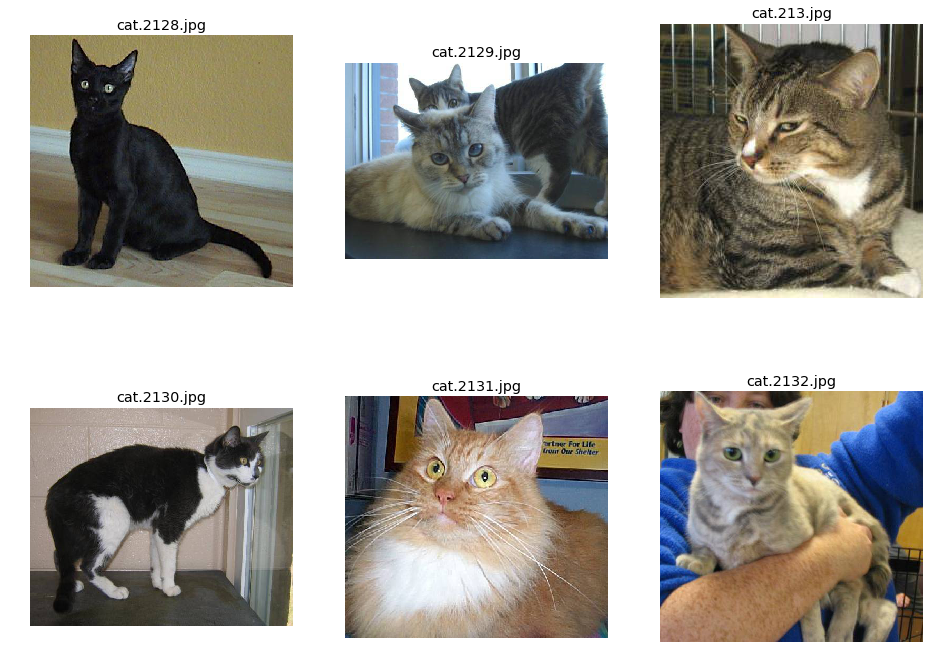

In [11]:
utils.imgs.plot_samples_from_dir(TRAIN_PATH, shuffle=True)

In [7]:
# Slow
trn_targs = metadata.get_one_hots_from_fold(cfg.METADATA_PATH, fold, c.TRAIN, 
                                            dogscats.LABEL_NAMES)[:SAMPLE]
val_targs = metadata.get_one_hots_from_fold(cfg.METADATA_PATH, fold, c.VAL, 
                                            dogscats.LABEL_NAMES)

In [8]:
img_reader = 'pil'
trn_dataset = datasets.datasets.FileDataset(
    trn_fpaths, img_reader, trn_targs, TRANSFORMS[c.TRAIN])
val_dataset = datasets.datasets.FileDataset(
    val_fpaths, img_reader, val_targs, TRANSFORMS[c.VAL])
tst_dataset = datasets.datasets.FileDataset(
    tst_fpaths, img_reader, None, TRANSFORMS[c.TEST])
print("trn",len(trn_dataset),"val",len(val_dataset))

trn_loader = data_loaders.get_data_loader(trn_dataset, TRAIN_CONFIG['batch_size'], 
                                          shuffle=True, n_workers=4, pin_memory=True)
val_loader = data_loaders.get_data_loader(val_dataset, TRAIN_CONFIG['batch_size'],
                                          shuffle=False, n_workers=4, pin_memory=True)
tst_loader = data_loaders.get_data_loader(tst_dataset, TRAIN_CONFIG['batch_size'],
                                          shuffle=False, n_workers=2, pin_memory=False)

trn 21250 val 3750


In [9]:
inputs,targets,img_paths = next(iter(trn_loader))
inputs.size(),targets.size(),img_paths[:3]

(torch.Size([64, 3, 256, 256]),
 torch.Size([64, 2]),
 ['/bigguy/data/dogscats/datasets/inputs/trn_jpg/cat.6963.jpg',
  '/bigguy/data/dogscats/datasets/inputs/trn_jpg/cat.6170.jpg',
  '/bigguy/data/dogscats/datasets/inputs/trn_jpg/cat.4984.jpg'])

## Train

In [ ]:
resnet = models.resnet.get_resnet34(pretrained=True, n_freeze=99999)
resnet = models.builder.cut_model(resnet, -1)
classifier = models.builder.get_classifier(in_feat=512, n_classes=DATA_CONFIG['n_classes'],
                                           activation=nn.Softmax(), p=0.5)
model = models.resnet.SimpleResnet(resnet, classifier)
model = model.cuda()
# outputs = model(Variable(inputs))
# print(outputs.size(), targets.size())

In [ ]:
# Load existing weights (optional)
experiment_name = 'BaselineSimpleResnet-Adam-ScheduledLR-img256-lr0.001-wd1e-05-bs32-fold5K-id767AD'
epoch = 30
exp_utils.load_weights_by_exp_and_epoch(model, experiment_name, epoch)

In [11]:
# Initialize trainer
criterion = F.binary_cross_entropy
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                       TRAIN_CONFIG['initial_lr'], weight_decay=TRAIN_CONFIG['weight_decay'])
lr_adjuster = learning_rates.ScheduledLR(TRAIN_CONFIG['initial_lr'], 'epoch', 
                                         TRAIN_CONFIG['lr_schedule'])
trainer = trainers.Trainer(criterion, criterion, optimizer, lr_adjuster)

In [12]:
# Experiment config
NEW_EXP_NAME = 'Baseline'
RESUME_EXP_NAME = None #'BaselineSimpleResnet-Adam-ScheduledLR-img256-lr0.001-wd0.0005-bs64-fold4K-id84E8D'
if not RESUME_EXP_NAME:
    EXP_NAME_ARGS = [utils.general.get_class_name(model), 
                    utils.general.get_class_name(optimizer), 
                    utils.general.get_class_name(lr_adjuster),
                    'img'+str(DATA_CONFIG['img_rescale']),
                    'lr'+str(TRAIN_CONFIG['initial_lr']),
                    'wd'+str(TRAIN_CONFIG['weight_decay']),
                    'bs'+str(TRAIN_CONFIG['batch_size']),
                    str(DATA_CONFIG['dset_fold'])]
    EXPERIMENT_NAME = exp_utils.generate_display_name(NEW_EXP_NAME, EXP_NAME_ARGS)
    METRICS = [metric.Loss(), metric.Accuracy(), metric.F2Score()]
    AUX_METRICS = [metric.AuxiliaryMetric('LearningRate', 'lr'), 
                   metric.AuxiliaryMetric('SystemMemory', 'mb')]
    VISUALIZERS = [Viz(EXPERIMENT_NAME)]

    EXP_CONFIG = {
        'name': EXPERIMENT_NAME,
        'parent_dir': cfg.PATHS['experiments'],
        'metrics': METRICS,
        'aux_metrics': AUX_METRICS,
        'visualizers': VISUALIZERS,
        'data': DATA_CONFIG,
        'training': TRAIN_CONFIG,
        'other': OTHER_CONFIG,
        'transforms': TRANSFORMS[c.TRAIN],
        'hardware': HARDWARE_CONFIG,
        'model': model,
        'optimizer': optimizer,
        'lr_adjuster': lr_adjuster,
        'criterion': criterion
    }

In [ ]:
# Resume experiment
exp = Experiment(RESUME_EXP_NAME, cfg.PATHS['experiments'])
exp.resume(verbose=True)
trainer = trainers.Trainer(criterion, criterion, exp.optim, lr_adjuster)

In [ ]:
# Create new experiment
exp = Experiment(EXP_CONFIG['name'], cfg.PATHS['experiments'])
exp.init(EXP_CONFIG)
print(exp.name)

In [ ]:
exp.train(trainer, trn_loader, val_loader)

## Predict

In [48]:
# Load model from exp epoch
exp.load_model_state(epoch=10)
model = exp.model

In [ ]:
# OR load custom model weights
exp_name = RESUME_EXP_NAME
w_path = os.path.join(cfg.PATHS['experiments'], exp_name, 'weights', 'weights-30.th')
models.utils.load_weights(model, w_path)

In [49]:
%time val_probs = predictions.get_probabilities(model, val_loader)

CPU times: user 3.34 s, sys: 772 ms, total: 4.12 s
Wall time: 4.03 s


In [53]:
pred_fpath = predictions.get_prediction_fpath(basename='my_exp', dset=c.VAL)
_ = predictions.save_or_append_pred_to_file(pred_fpath, val_probs)

Acc 0.990666666667 F2 0.990666666667 BCE 0.030270898714661598


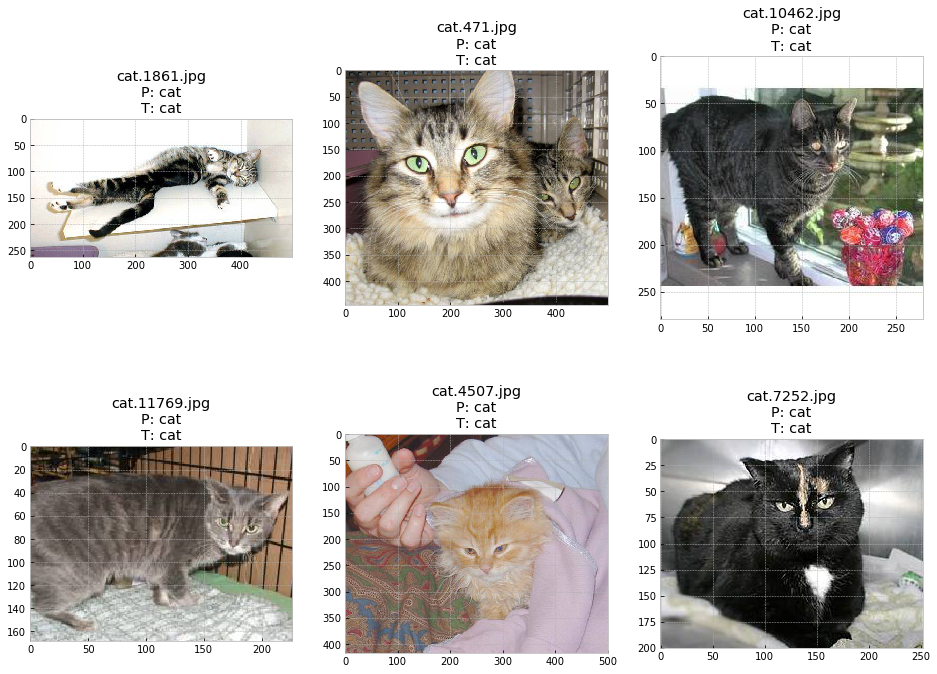

In [54]:
thresh = TRAIN_CONFIG['threshold']
acc = metric_utils.get_accuracy(val_probs > thresh, val_targs)
f2 = metric_utils.get_metric_in_blocks(val_probs > thresh, val_targs, 
                                       1000, metric_utils.get_f2_score)
loss = metric_utils.get_cross_entropy_loss(val_probs, val_targs)
print("Acc",acc,"F2",f2,"BCE",loss)
utils.imgs.plot_sample_preds(val_fpaths, val_probs > 0.5, val_targs, 
                             dogscats.LABEL_NAMES)

In [55]:
%time tst_probs = predictions.get_probabilities(model, tst_loader)

CPU times: user 9.9 s, sys: 2.12 s, total: 12 s
Wall time: 20.8 s


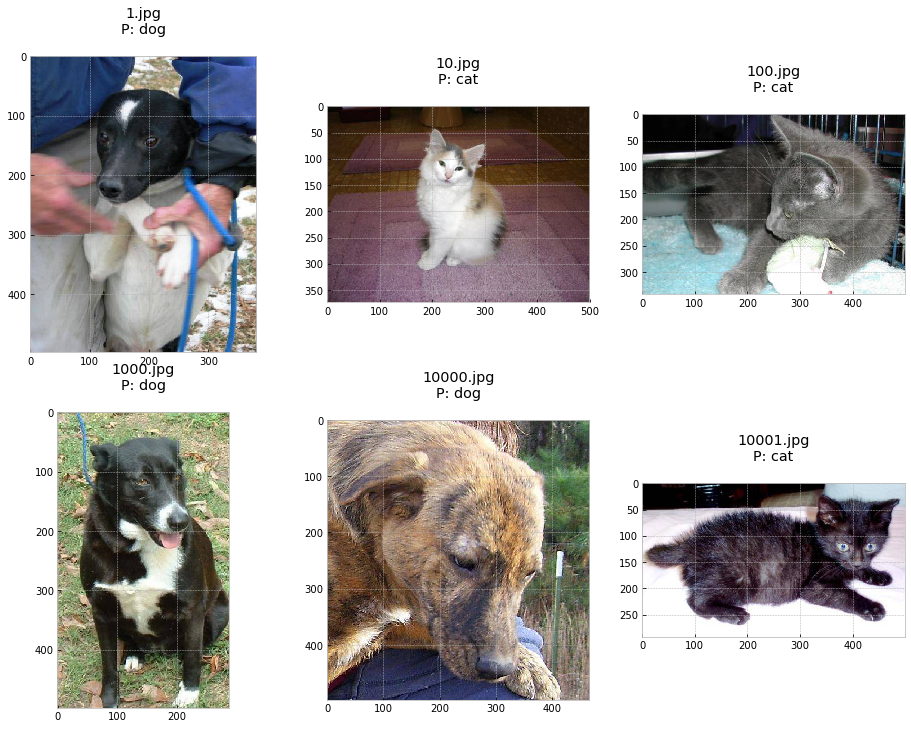

In [56]:
pred_fpath = predictions.get_prediction_fpath(basename='my_exp', dset=c.TEST)
_ = predictions.save_or_append_pred_to_file(pred_fpath, tst_probs)
tst_probs = predictions.load_pred(pred_fpath, numpy=True)
utils.imgs.plot_sample_preds(tst_fpaths, tst_probs > thresh, 
                             None, dogscats.LABEL_NAMES)

## Ensemble

In [20]:
member_fpaths = predictions.list_local_preds(dset=c.TEST, fnames_only=False)
member_fpaths

['/bigguy/data/dogscats/predictions/my_exp_tst.bc']

In [21]:
ens_fpath = ensembles.get_ensemble_fpath(basename='my_exp', dset=c.TEST)
_ = ensembles.ens_prediction_files(
    ens_fpath, member_fpaths, block_size=1000, method=c.MEAN)
ens_probs = predictions.load_pred(ens_fpath, numpy=True)

Time 0.0m 0.00s


## Submit

In [57]:
tst_probs = predictions.load_pred(pred_fpath, numpy=True)

In [58]:
sub_fpath = submissions.get_sub_path_from_pred_path(pred_fpath)
fnames = utils.files.get_fnames_from_fpaths(tst_fpaths)
sub_ids = [f.split('.')[0] for f in fnames]
tst_probs = np.clip(tst_probs, .005, .995) #good for BCE problems
submissions.make_preds_submission(sub_fpath, sub_ids, 
                                  np.expand_dims(tst_probs[:,1],1), 
                                  dogscats.SUB_HEADER)

In [ ]:
# https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
# Public Leaderboard .0566, Top 8%
# kg submit -m 'my sub' -c dogs-vs-cats-redux-kernels-edition -v -u USERNAME -p PASSWORD planet_tst.csv
FileLink(sub_fpath)

## Evaluate

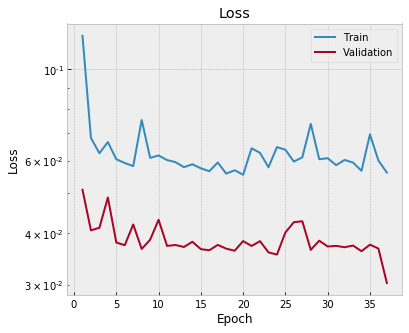

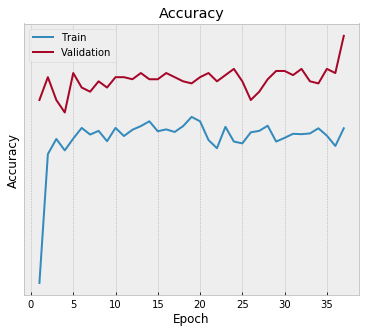

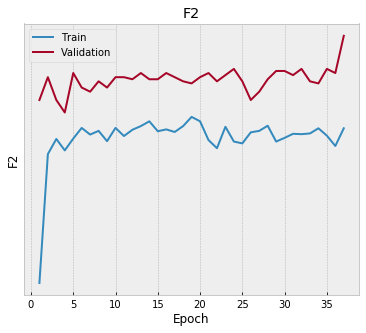

In [59]:
# Review Experiment
exp_name = 'BaselineSimpleResnet-Adam-ScheduledLR-img256-lr0.001-wd0.0005-bs64-fold4K-id84E8D'
exp = Experiment(exp_name, cfg.PATHS['experiments'])
exp.review(verbose=False)
exp.history.plot()

In [60]:
# Load Pred
fname = 'my_exp_val.bc'
thresh = TRAIN_CONFIG['threshold']
probs = predictions.load_pred(os.path.join(cfg.PATHS['predictions'], fname))
preds = predictions.get_predictions(probs, thresh)

In [61]:
# View preds, probs, and targets
eval_df = evaluate.get_evaluate_df(preds, probs, val_targs, 
                                   val_fpaths, dogscats.LABEL_NAMES)
eval_df[:5]

fname  cat  dog  p_cat  p_dog  t_cat  t_dog  \
0   cat.1861.jpg    1    0   0.97   0.03      1      0   
1    cat.471.jpg    1    0   1.00   0.00      1      0   
2  cat.10462.jpg    1    0   1.00   0.00      1      0   
3  cat.11769.jpg    1    0   1.00   0.00      1      0   
4   cat.4507.jpg    1    0   1.00   0.00      1      0   

                                               fpath  
0  /bigguy/data/dogscats/datasets/inputs/trn_jpg/...  
1  /bigguy/data/dogscats/datasets/inputs/trn_jpg/...  
2  /bigguy/data/dogscats/datasets/inputs/trn_jpg/...  
3  /bigguy/data/dogscats/datasets/inputs/trn_jpg/...  
4  /bigguy/data/dogscats/datasets/inputs/trn_jpg/...

In [62]:
# View preds by label
LABEL = 'dog'
dog_preds_by_targ = evaluate.get_preds_by_target_label(
    eval_df, LABEL, condensed=False)
dog_preds_by_pred = evaluate.get_preds_by_predicted_label(
    eval_df, LABEL, condensed=False)
dog_preds_by_targ[:5]

fname  cat  dog  p_cat  p_dog  t_cat  t_dog  \
1993   dog.6470.jpg    0    1   0.00   1.00      0      1   
722    dog.1607.jpg    0    1   0.00   1.00      0      1   
2499   dog.7518.jpg    0    1   0.01   0.99      0      1   
2316  dog.11520.jpg    0    1   0.01   0.99      0      1   
2097   dog.1657.jpg    0    1   0.01   0.99      0      1   

                                                  fpath  
1993  /bigguy/data/dogscats/datasets/inputs/trn_jpg/...  
722   /bigguy/data/dogscats/datasets/inputs/trn_jpg/...  
2499  /bigguy/data/dogscats/datasets/inputs/trn_jpg/...  
2316  /bigguy/data/dogscats/datasets/inputs/trn_jpg/...  
2097  /bigguy/data/dogscats/datasets/inputs/trn_jpg/...

fname  cat  dog  p_cat  p_dog  t_cat  t_dog  \
410    dog.3920.jpg    1    0   0.93   0.07      0      1   
516   dog.11731.jpg    1    0   0.96   0.04      0      1   
1403   dog.5529.jpg    1    0   0.96   0.04      0      1   
442   dog.10939.jpg    1    0   0.96   0.04      0      1   

                                                  fpath  
410   /bigguy/data/dogscats/datasets/inputs/trn_jpg/...  
516   /bigguy/data/dogscats/datasets/inputs/trn_jpg/...  
1403  /bigguy/data/dogscats/datasets/inputs/trn_jpg/...  
442   /bigguy/data/dogscats/datasets/inputs/trn_jpg/...

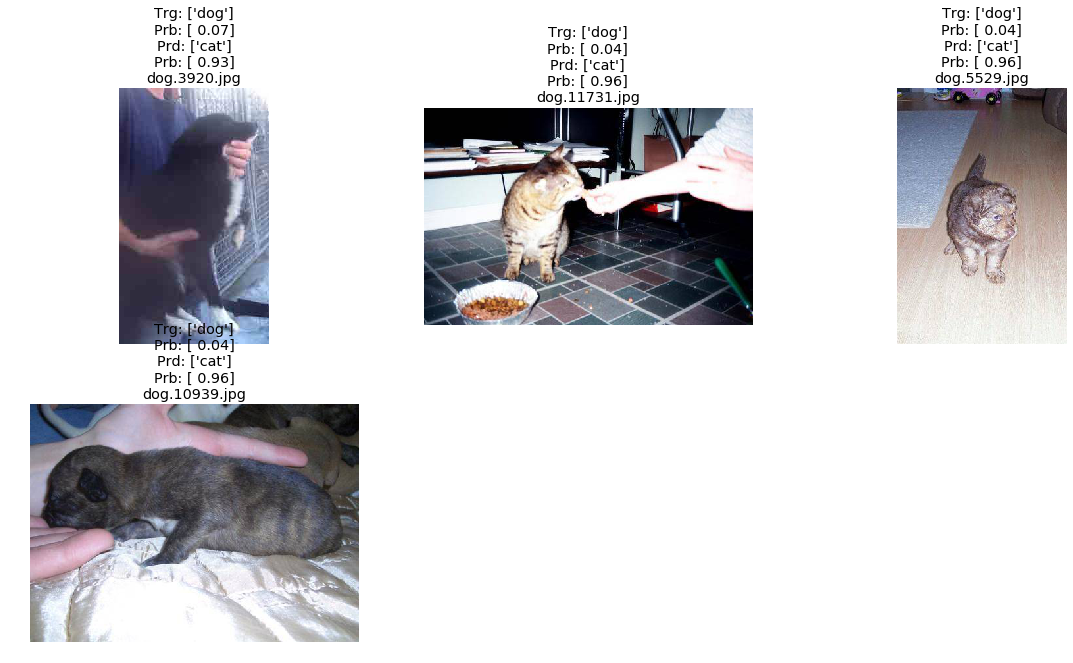

In [63]:
# View preds by probability

# Confident dogs and right (TP)
confident_dogs_tp = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 1, p_min=0.9, p_max=1.0)
# Confident dogs and wrong (FP)
confident_dogs_fp = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 0, p_min=0.9, p_max=1.0)
# Unconfident dogs and right (TN)
unconfident_dogs_tn = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 0, p_min=0.0, p_max=0.1)
# Unconfident dogs and wrong (FN)
unconfident_dogs_fn = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 1, p_min=0.0, p_max=0.1)

# Annotation errors?
evaluate.plot_predictions(unconfident_dogs_fn, dogscats.LABEL_NAMES)
unconfident_dogs_fn

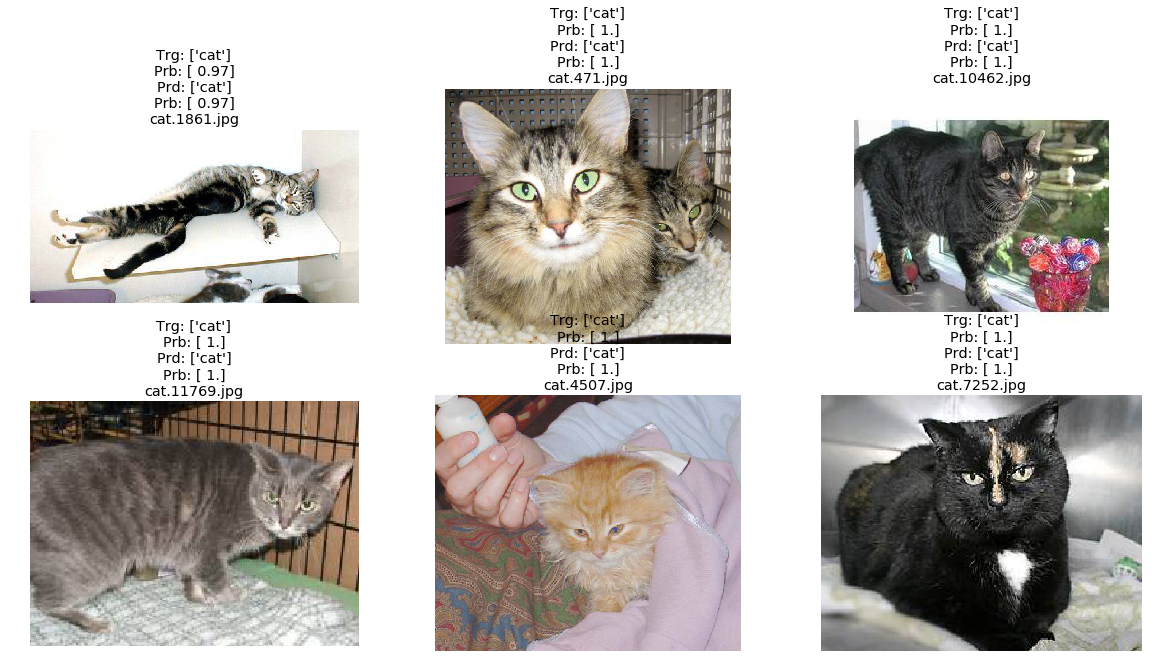

In [64]:
# View predictions and probabilities
evaluate.plot_predictions(eval_df, dogscats.LABEL_NAMES)

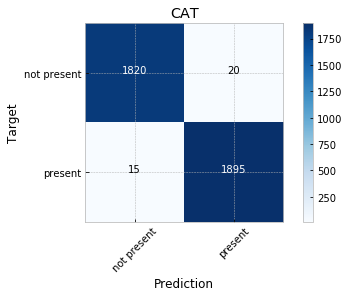

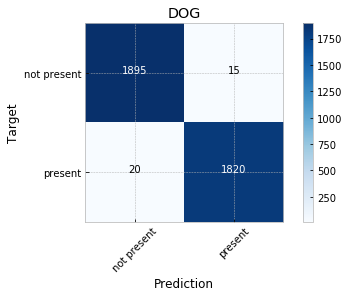

In [65]:
# Confusion Matrix
evaluate.plot_label_level_cms(eval_df, dogscats.LABEL_NAMES)

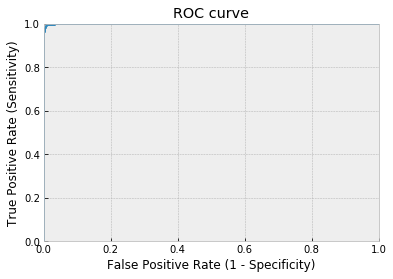

In [66]:
# Plot ROC Curve
evaluate.plot_roc_curve(np.array(probs), val_targs)